In [3]:
# Step 1: Load and Explore the Dataset
import pandas as pd

In [4]:
# Load the dataset
from google.colab import files
uploaded = files.upload()

Saving adult_with_headers.csv to adult_with_headers (1).csv


In [5]:
df = pd.read_csv('adult_with_headers.csv')


In [6]:
# Display basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


In [7]:
# Display first few rows
print(df.head())

   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  
0          2174             0              40   United-States   <=50

In [8]:
# Check for missing values
print(df.isnull().sum())


age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [9]:
# Step 2: Handle Missing Values
# Filling missing values (example: replace with mode for categorical, mean for numerical)
for column in df.columns:
    if df[column].dtype == 'object':  # Categorical
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:  # Numerical
        df[column].fillna(df[column].mean(), inplace=True)


In [10]:
# Step 3: Apply Scaling to Numerical Features
# We'll apply both Standard Scaling and Min-Max Scaling.
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns



In [11]:
# Standard Scaling
scaler_standard = StandardScaler()
df_standard = df.copy()
df_standard[num_cols] = scaler_standard.fit_transform(df_standard[num_cols])

In [12]:
# Min-Max Scaling
scaler_minmax = MinMaxScaler()
df_minmax = df.copy()
df_minmax[num_cols] = scaler_minmax.fit_transform(df_minmax[num_cols])


In [13]:
# Standard Scaling is used when data follows a normal distribution.
# Min-Max Scaling is useful when data is not normally distributed and needs to be bounded between a specific range (e.g., [0,1]).

In [14]:
# Step 4: Encoding Categorical Variables
# One-Hot Encoding for categorical features with less than 5 unique categories.
# Label Encoding for categorical features with more than 5 unique categories.

from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

In [15]:
# Apply encoding
for col in cat_cols:
    if df[col].nunique() < 5:
        df = pd.get_dummies(df, columns=[col], drop_first=True)  # One-Hot Encoding
    else:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])  # Label Encoding


In [16]:
# Step 5: Feature Engineering
import numpy as np

# Creating new features (example: Age Groups and Work Hours per Week Ratio)
df['Age_Group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle-aged', 'Old'])
df['Work_Hours_Ratio'] = df['hours_per_week'] / 168  # Normalizing work hours by total weekly hours

# Log Transformation on skewed feature
df['log-capital-gain'] = np.log1p(df['capital_gain'])  # log(1+x) to handle zero values


In [17]:
# Step 6: Feature Selection
# Removing Outliers with Isolation Forest
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df[num_cols])
df = df[outliers == 1]  # Keep only non-outliers


In [18]:
!pip install ppscore

In [19]:
import ppscore
print("PPS installed successfully!")

PPS installed successfully!


In [20]:
# Feature Importance with Predictive Power Score (PPS)
import ppscore as pps

pps_matrix = pps.matrix(df)
print(pps_matrix[['x', 'y', 'ppscore']].sort_values(by='ppscore', ascending=False))


                 x                 y  ppscore
0              age               age      1.0
152           race              race      1.0
57       education         education      1.0
58       education     education_num      1.0
75   education_num         education      1.0
..             ...               ...      ...
140   relationship      income_ >50K      0.0
142   relationship  Work_Hours_Ratio      0.0
143   relationship  log-capital-gain      0.0
144           race               age      0.0
172   capital_gain      capital_loss      0.0

[324 rows x 3 columns]


<ipython-input-21-f7c49d1049c6>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


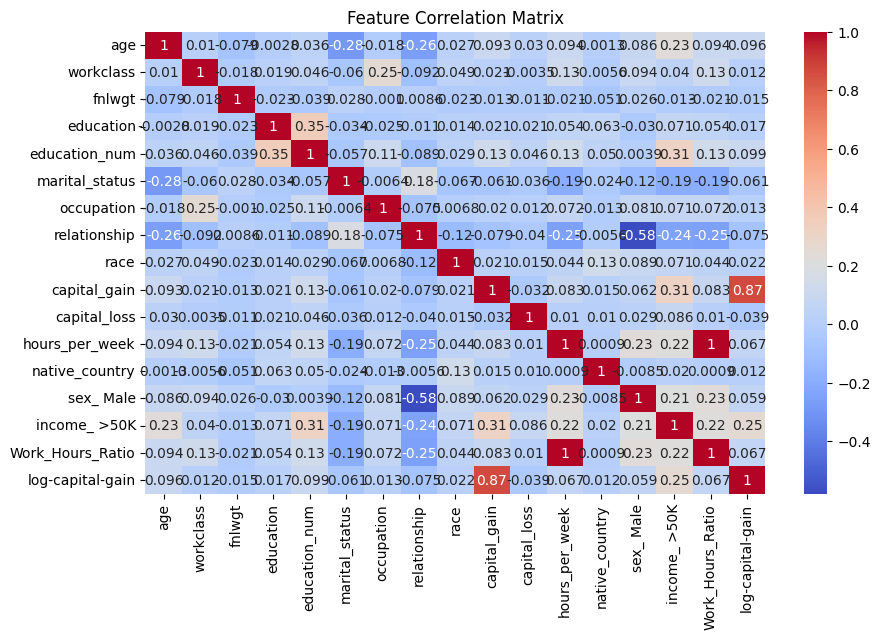

In [21]:
# Comparison with Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()